# Running FEISTY with time-series forcing from CESM

Kristen ran a single JRA cycle with 0.1&deg; resolution on frontera, and then converted output to time series.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.TL319_g17.4p2z.001.yml`.
This was run on a casper compute node with 15 GB of memory.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import dask
import matplotlib.pyplot as plt
import nc_time_axis  # needed for time series plot for some reason
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client, wait
from dask_jobqueue import PBSCluster

import feisty

## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [3]:
# Read settings from YAML
feisty_config_file = 'feisty-config.TL319_t13.4p2z.001.yml'
with open(feisty_config_file) as f:
    feisty_config = yaml.safe_load(f)

## Set up Dask cluster

Since the data in `ds` is chunked in `nlat` and `nlon`, we use a `dask` cluster to configure the parallelization.
For running a single year, we request 10 GB per worker.

In [4]:
mem = 10  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:00:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config['num_workers'])
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.60:44024,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Run the model

Currently, the `feisty-config.TL319_t13.4p2z.001.yml` is configured to run a single year (1958):

```yaml
start_date: '1980-01-01'
end_date: '1980-12-31'
```

And it is initialized from the last timestep of a 103 spin-up run:

```yaml
initial_conditions:
  root_dir: /glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/FEISTY_ic
  ic_file: highres_spinup.0103-12-31.zarr
```

In [5]:
%%time

print(f'Running FEISTY...')
ds_out = feisty.config_and_run_from_yaml(feisty_config)
ds_out["biomass"]

Running FEISTY...
Starting template generation at 12:10:40
Writing ./highres_1980.zarr
Calling to_zarr...
Writing ./highres_1980-12-31.zarr
Calling to_zarr...
CPU times: user 2min 20s, sys: 6.13 s, total: 2min 26s
Wall time: 17min 5s


<xarray.DataArray 'biomass' (time: 365, group: 9, nlat: 2400, nlon: 3600)>
dask.array<biomass-config_and_run_from_dataset, shape=(365, 9, 2400, 3600), dtype=float64, chunksize=(365, 9, 8, 1200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 1980-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 ... 3593 3594 3595 3596 3597 3598 3599

### Plotting

Make a plot of `biomass` over time at a specified column.
This specific column was chosen somewhat randomly, and represents (74.6&deg; S, 152.5&deg; E).

CPU times: user 462 ms, sys: 14 ms, total: 476 ms
Wall time: 520 ms


Text(0.5, 1.0, 'Biomass at (91, 3175)')

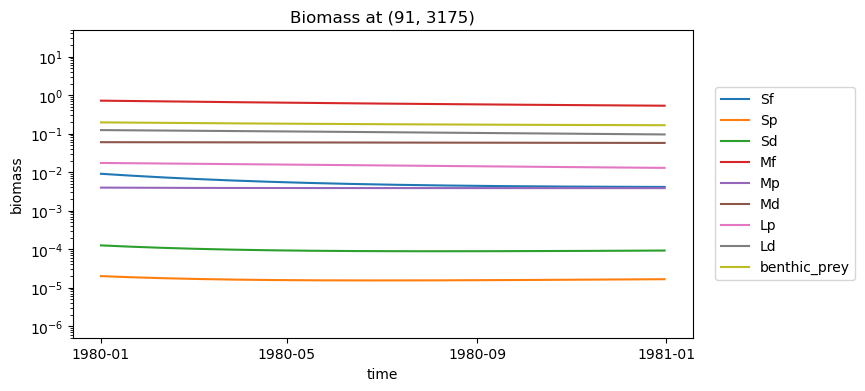

In [6]:
%%time

# Select column for time series plot
nlat = 91
nlon = 3175

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    ds_out['biomass'].isel(nlat=nlat, nlon=nlon).sel(group=group).plot()
ax.set_ylim([5e-7, 50])
ax.set_yscale('log')
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
plt.title(f'Biomass at ({nlat}, {nlon})');

CPU times: user 1.62 s, sys: 174 ms, total: 1.79 s
Wall time: 1.86 s


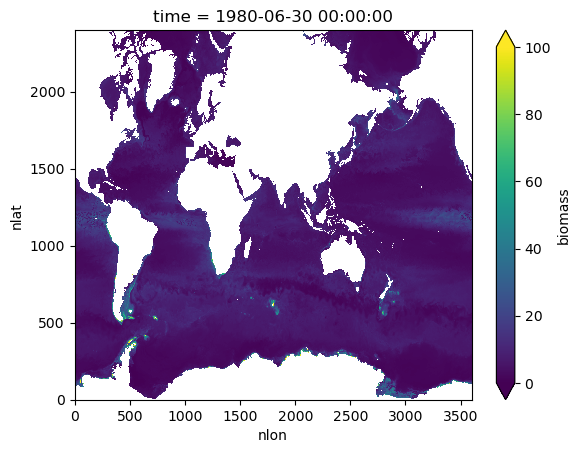

In [7]:
%%time

ds_out["biomass"].isel(time=180).sum('group', skipna=False).plot(vmin=0, vmax=100)